In [1]:
#!wget --no-cache -O init.py -q https://raw.githubusercontent.com/UDEA-Esp-Analitica-y-Ciencia-de-Datos/EACD-02-ESTADISTICA/master/init.py
#import init; init.init(force_download=False); 
from IPython.display import Image

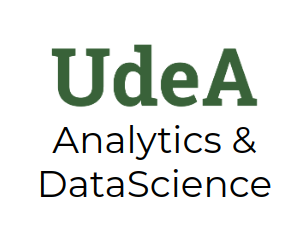

In [2]:
Image("../../docs/udea-datascience.png")

**Desarrollado por:** Javier Fernando Botía Valderrama

*Docente del Departamento de Ingeniería de Sistemas*

**Materia:** Estadística y Análisis Exploratorio

**Departamento:** Posgrado en Ingeniería

**Facultad de Ingeniería - Universidad de Antioquia**

In [3]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import io
import requests
import numpy as np
import seaborn as sns

from sklearn.neighbors import KernelDensity # Densidad Kernel (Scikit-Learn)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut 
from statsmodels.nonparametric.kde import kernel_switch
import statsmodels.api as sm
import scipy.stats
from scipy.stats import ks_2samp
from scipy import special # Funciones especiales
from sklearn.preprocessing import MinMaxScaler

In [4]:
nombres = ['Company 1', 'Company 2', 'Company 3', 'Company 4', 'Company 5', 'Company 6', 'Company 7', 'Company 8', 'Company 9', 'Company 10']
url = "https://raw.githubusercontent.com/javierfernandobotia/AnalisisAvanzadoDatos/main/stock.dat"

download = requests.get(url).content
data = pd.read_table(io.StringIO(download.decode('utf-8')), sep=',', names = nombres)
# Es importante codificarlo a utf-8
display(data.head(20))

,Company 1,Company 2,Company 3,Company 4,Company 5,Company 6,Company 7,Company 8,Company 9,Company 10
0,17.219,50.500,18.750,43.000,60.875,26.375,67.750,19.000,48.750,34.875
1,17.891,51.375,19.625,44.000,62.000,26.125,68.125,19.125,48.750,35.625
2,18.438,50.875,19.875,43.875,61.875,27.250,68.500,18.250,49.000,36.375
3,18.672,51.500,20.000,44.000,62.625,27.875,69.375,18.375,49.625,36.250
4,17.438,49.000,20.000,41.375,59.750,25.875,63.250,16.500,47.500,35.500
5,18.109,49.000,19.500,41.875,59.625,26.625,66.250,17.125,47.750,34.375
6,18.563,49.375,19.125,42.500,60.750,27.250,65.750,16.875,47.875,34.000
7,18.672,50.125,19.250,43.000,61.750,28.000,66.000,16.875,47.250,34.625
8,18.563,49.750,19.000,43.250,61.750,29.000,65.750,17.125,47.000,34.875
9,19.063,50.500,19.125,43.875,61.875,29.625,66.875,17.750,47.375,36.000


# KS Test

## KS Test de una muestra

El test KS o test Kolmogorov–Smirnov determina si dos muestras son significativamente diferentes una de la otra, mediante una comprobación de la uniformidad de los valores de los datos (distribución uniforme) o mediante un análisis si dos distribuciones de probabilidad son diferentes entre sí. Para lograr este análisis, el test KS cuantifica una distancia entre una función de distribución de probabilidad de prueba de la muestra y la función de distribución acumulativa de una distribución de referencia o conocida. Además, se puede cuantificar una distancia entre funciones de probabilidad de prueba de dos muestras.

La hipótesis nula del test asume que los valores de los datos son uniformemente distribuidos entre 0 y 1. Si se rechaza la hipótesis nula, entonces los valores no son uniformemente distribuidos entre 0 y 1. El hecho de que no se rechace la hipótesis nula no significa necesariamente que los valores sigan la distribución uniforme. Pueden ser otra distribución como la *normal o Gaussiana*.

Vamos a considerar:

*   $H_0$ : Los datos analizados siguen una distribución de densidad de probabilidad.

*   $H_1$ : Los datos analizados **no** siguen una distribución de densidad de probabilidad


In [5]:
nombres = ['beta', 'gamma', 'expon', 'chi2', 'norm', 't', 'uniform']
ks_valor = []
p_valor = []
Data = data.values
Caracteristicas = data.columns

for distribuciones in nombres:
    dis = getattr(scipy.stats, distribuciones)
    for _,n in enumerate(Caracteristicas):
      A = np.asarray(data[n])
      par = dis.fit(A) # Calculamos la máxima verosimilitud de los datos, de acuerdo a la distribución de densidad de probabilidad
      D, p = scipy.stats.kstest(data[n], distribuciones, N = 50, mode = 'auto', args = par) 
      # Colocamos los datos que queremos analizar (KS solo analiza una columna o característica de los datos, 
      # por esta razón, se usa un ciclo for para analizar todas las columnas de interés de la base de datos)
      # N = tamaño de la muestra de los datos (recomiendo N >= 20)
      pp = np.around(p, 10) # Se muestran las 10 primeras cifras significativas del valor p
      DD = np.around(D, 5) # Se muestran las 5 primeras cifras significativas del valor KS
      p_valor.append(pp)
      ks_valor.append(DD)

ks_valor = np.asarray(ks_valor)
p_valor = np.asarray(p_valor)

ks_valor = ks_valor.reshape(len(nombres), data.shape[1]) 
# Los valores ks son organizados en una matriz de D-distribuciones de probabilidad x Número de columnas o características de los datos 
p_valor = p_valor.reshape(len(nombres), data.shape[1]) 
# Los valores p son organizados en una matriz de D-distribuciones de probabilidad x Número de columnas o características de los datos

ks_valor = pd.DataFrame(ks_valor, index = nombres, columns = Caracteristicas)
p_valor = pd.DataFrame(p_valor, index = nombres, columns = Caracteristicas)

C:\Users\Usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_continuous_distns.py:684: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


In [6]:
display(ks_valor)

,Company 1,Company 2,Company 3,Company 4,Company 5,Company 6,Company 7,Company 8,Company 9,Company 10
beta,0.08797,0.12668,0.10521,0.06482,0.06296,0.14120,0.22398,0.10843,0.04375,0.04757
gamma,0.11270,0.18885,0.11435,0.06464,0.06004,0.13458,0.08556,0.11004,0.08022,0.05840
expon,0.20570,0.23537,0.21839,0.27240,0.26513,0.22303,0.24254,0.29604,0.33331,0.22915
chi2,0.12164,0.19015,0.12092,0.22497,0.06004,0.13868,0.26022,0.10467,0.08524,0.05485
norm,0.11124,0.18219,0.10836,0.11711,0.05876,0.13823,0.14386,0.11074,0.07538,0.05872
t,0.11126,0.18218,0.10840,0.11710,0.05876,0.13824,0.14386,0.11076,0.07536,0.05868
uniform,0.16573,0.23127,0.17107,0.22386,0.13314,0.14340,0.19897,0.16741,0.23841,0.11672


In [7]:
display(p_valor)

,Company 1,Company 2,Company 3,Company 4,Company 5,Company 6,Company 7,Company 8,Company 9,Company 10
beta,7.600000e-07,0.0,1.300000e-09,0.00065,0.001023,0.0,0.000000,4.000000e-10,0.051156,0.026280
gamma,1.000000e-10,0.0,0.000000e+00,0.00068,0.002027,0.0,0.000002,2.000000e-10,0.000009,0.002939
expon,0.000000e+00,0.0,0.000000e+00,0.00000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000
chi2,0.000000e+00,0.0,0.000000e+00,0.00000,0.002027,0.0,0.000000,1.600000e-09,0.000002,0.006336
norm,1.000000e-10,0.0,4.000000e-10,0.00000,0.002713,0.0,0.000000,1.000000e-10,0.000039,0.002738
t,1.000000e-10,0.0,4.000000e-10,0.00000,0.002713,0.0,0.000000,1.000000e-10,0.000039,0.002759
uniform,0.000000e+00,0.0,0.000000e+00,0.00000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000


Observen que los valores $\rho$ para las variables *Company 1* - *Company 8* cumplen con el criterio $\rho_{value} \leq 0.05$. En este caso, rechazamos la hipótesis nula y por consiguiente, hay suficiente evidencia para decir que la muestra de los datos $N = 50$ tomadas por cada variable *no* provienen desde las distribuciones de densidad de probabilidad continuas usadas para el test. Este mismo caso se daría para la variable *Company 10*.

Por otra parte, al aplicar el test KS con la variable *Company 9*, se encontró que la distribución beta genero un $\rho_{value} > 0.05$. Esto nos indica que hay suficiente evidencia para determinar que la variable *Company 9* sigue una distribución beta. Verifiquemos mediante una comparación grafica si hay similitud entre el histograma de esta variable y la distribución beta.

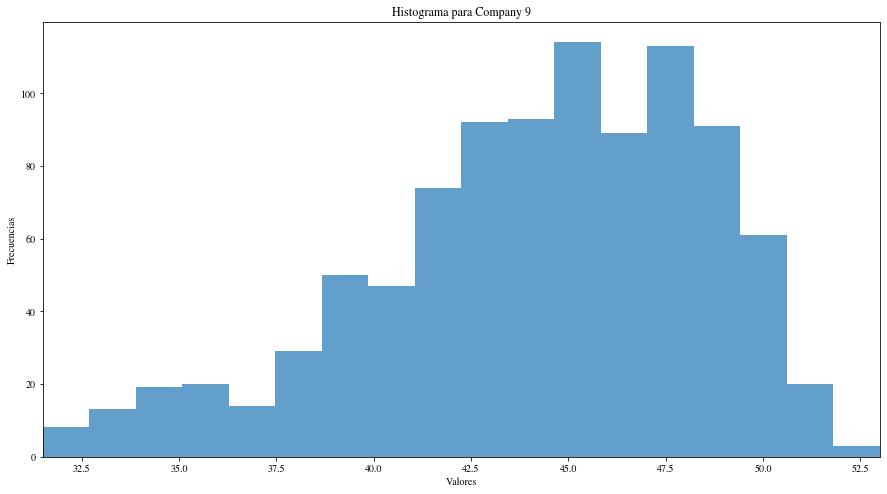

In [8]:
matplotlib.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
fig = plt.figure(figsize=(15,8))
plt.hist(data['Company 9'], bins = 'fd', alpha=0.7) # fd = regla de Freedman-Diaconis
plt.xlim(data['Company 9'].min(), data['Company 9'].max()) # Límita el valor mínimo y máximo en eje x de la gráfica
plt.xlabel('Valores')
plt.ylabel('Frecuencias')
plt.title('Histograma para Company 9')
plt.show()

In [9]:
from scipy.stats import beta # distribución de densidad de probabilidad beta

par = beta.fit(data['Company 9']) 
# A partir de los datos, calculamos los parámetros de ajuste de la distribución usando la Estimación de la Máxima Verosimilitud (MLE)
print(par)

(16.79633416667313, 3.640773538974222, 2.0776788874788314, 51.26743746587964)


C:\Users\Usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_continuous_distns.py:684: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


De acuerdo con https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html , los dos primeros valores de `par` corresponde a los parámetros de ajuste de la distribución de densidad de probabilidad beta y los dos últimos valores de `par` corresponde a la media y la desviación estándar.

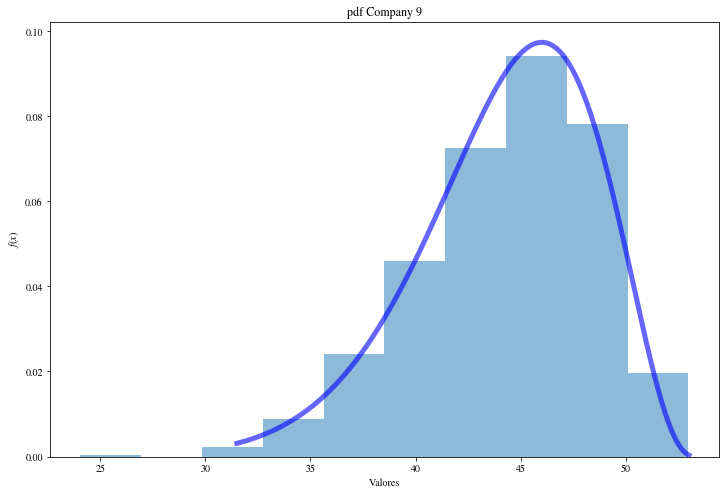

In [10]:
x_minimo = np.min(data['Company 9'].values)
x_maximo = np.max(data['Company 9'].values)
x = np.linspace(x_minimo, x_maximo, data['Company 9'].shape[0]) 
# Generamos un arreglo de valores para construir la función de densidad de probabilidad beta

beta_dist = beta.pdf(x, a = par[0], b = par[1], loc = par[2], scale = par[3])

fig = plt.figure(figsize=(12,8))
plt.plot(x, beta_dist, 'b-', lw = 5, alpha = 0.6, label='pdf beta Company 9')
plt.hist(beta.rvs(size = data['Company 9'].shape[0], a = par[0], b = par[1], loc = par[2], scale = par[3]), density=True, histtype='stepfilled', alpha=0.5) # rvs significa variable aleatoria
plt.xlabel('Valores')
plt.ylabel('$f(x)$')
plt.title('pdf Company 9')
plt.show()

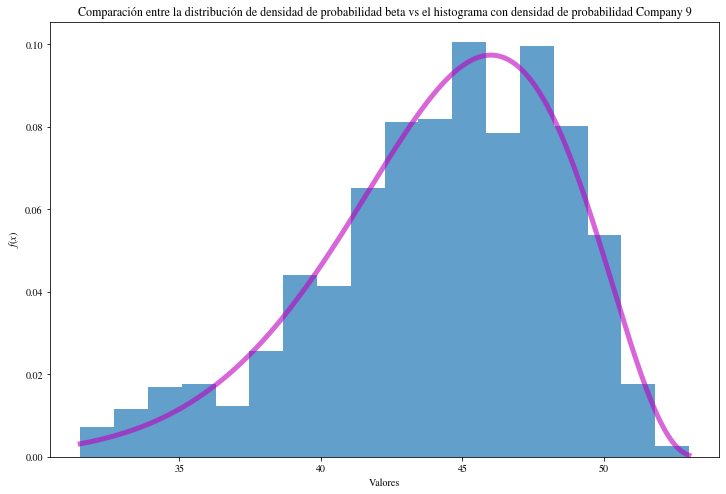

In [11]:
fig = plt.figure(figsize=(12,8))
plt.hist(data['Company 9'], density=True, bins = 'fd', alpha=0.7)
plt.plot(x, beta_dist, 'm-', lw = 5, alpha = 0.6, label='pdf beta Company 9')
plt.xlabel('Valores')
plt.ylabel('$f(x)$')
plt.title('Comparación entre la distribución de densidad de probabilidad beta vs el histograma con densidad de probabilidad Company 9')
plt.show()

Una vez encontrado cúal es la función de densidad de distribución de probabilidad que sigue la distribución de los datos para *Company 9* ¿Qué análisis se podría realizar? La clave es determinar la función de densidad acumulada o cdf para realizar un cálculo de probabilidades:

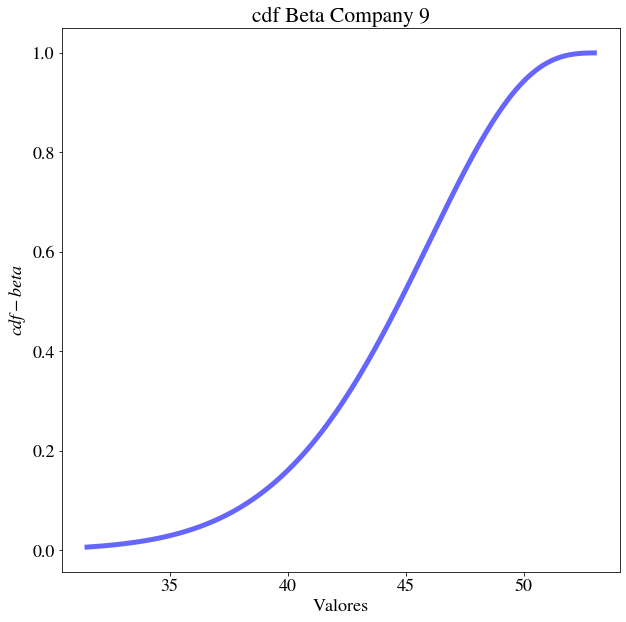

In [12]:
matplotlib.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

cdf_beta = beta.cdf(x, a = par[0], b = par[1], loc = par[2], scale = par[3])

plt.figure(figsize=(10,10))
plt.plot(x, cdf_beta, 'b-', lw = 5, alpha = 0.6, label='cdf Gaussiano')
plt.xlabel('Valores')
plt.ylabel('$cdf - beta$')
plt.title('cdf Beta Company 9')
plt.show()

¿Cuál es la probabilidad que los valores estén entre **45** y **50**?

In [13]:
Valor_referencia_1 = 45
Valor_referencia_2 = 50
cdf_45 = beta.cdf(Valor_referencia_1, a = par[0], b = par[1], loc = par[2], scale = par[3])
cdf_50 = beta.cdf(Valor_referencia_2, a = par[0], b = par[1], loc = par[2], scale = par[3])
print("La probabilidad que Company 9 tenga valores entre 45 y 50 es = {:.4f}".format(cdf_50 - cdf_45))

La probabilidad que Company 9 tenga valores entre 45 y 50 es = 0.4197


¿Cuál es la probabilidad que los valores sean **superiores a 50**?

In [14]:
Valor_referencia = 50
cdf_80 = beta.cdf(Valor_referencia, a = par[0], b = par[1], loc = par[2], scale = par[3])
print("la probabilidad de observar los precios superiores a 50 para Company 9 es = {:.4f}".format(1 - cdf_80))

la probabilidad de observar los precios superiores a 50 para Company 9 es = 0.0572


¿Cuál es la probabilidad que los valores sean **inferiores a 40**?

In [15]:
Valor_referencia = 40
cdf_40 = beta.cdf(Valor_referencia, a = par[0], b = par[1], loc = par[2], scale = par[3])
print("la probabilidad de observar los precios inferiores a 40 para Company 9 es = {:.4f}".format(cdf_40))

la probabilidad de observar los precios inferiores a 40 para Company 9 es = 0.1605


## KS Test de dos muestras

Otro tipo de test KS que podemos aplicar es la prueba KS test de dos muestras, que permite comparar una distribución de referencia con respecto a otra distribución. Vamos a considerar:

*   $H_0$ : Las dos distribuciones de densidad de probabilidad son idénticos.

*   $H_1$ : Las dos distribuciones de densidad de probabilidad no son idénticos.

In [16]:
nombres = ['beta', 'gamma', 'weibull_max','chi2', 'norm', 't', 'uniform', 'pearson3']
ks_valor = []
p_valor = []
Data = data.values
Caracteristicas = data.columns
Caracteristica_referencia = 'Company 8'

for distribuciones in nombres:
    dis = getattr(scipy.stats, distribuciones)
    for _,n in enumerate(Caracteristicas):
      A = np.asarray(data[Caracteristica_referencia])
      B = np.asarray(data[n])
      par = dis.fit(A) # Calculamos la máxima verosimilitud de los datos, de acuerdo a la distribución de densidad de probabilidad
      par_B = dis.fit(B) # Calculamos la máxima verosimilitud de los datos, de acuerdo a la distribución de densidad de probabilidad
      x_minimo = np.min(A)
      x_maximo = np.max(A)
      x_a = np.linspace(x_minimo, x_maximo, A.shape[0]) # Generamos un arreglo de valores para construir la función
      x_minimo = np.min(B)
      x_maximo = np.max(B)
      x_b = np.linspace(x_minimo, x_maximo, B.shape[0]) # Generamos un arreglo de valores para construir la función
      
      if distribuciones == 'beta':
        f_distribucion_1 = dis.pdf(x, a = par[0], b = par[1], loc = par[2], scale = par[3])
        f_distribucion_2 = dis.pdf(x_b, a = par_B[0], b = par_B[1], loc = par_B[2], scale = par_B[3])
      elif distribuciones == 'gamma':
        f_distribucion_1 = dis.pdf(x, a = par[0], loc = par[1], scale = par[2])
        f_distribucion_2 = dis.pdf(x_b, a = par_B[0], loc = par_B[1], scale = par_B[2])
      elif distribuciones == 'chi2':
        f_distribucion_1 = dis.pdf(x, df = par[0], loc = par[1], scale = par[2])
        f_distribucion_2 = dis.pdf(x_b, df = par_B[0], loc = par_B[1], scale = par_B[2])
      elif distribuciones == 't':
        f_distribucion_1 = dis.pdf(x, df = par[0], loc = par[1], scale = par[2])
        f_distribucion_2 = dis.pdf(x_b, df = par_B[0], loc = par_B[1], scale = par_B[2])  
      elif distribuciones == 'weibull_max':
        f_distribucion_1 = dis.pdf(x, c = par[0], loc = par[1], scale = par[2])
        f_distribucion_2 = dis.pdf(x_b, c = par_B[0], loc = par_B[1], scale = par_B[2])
      elif distribuciones == 'pearson3':
        f_distribucion_1 = dis.pdf(x, skew = par[0], loc = par[1], scale = par[2])
        f_distribucion_2 = dis.pdf(x_b, skew = par_B[0], loc = par_B[1], scale = par_B[2])    
      elif distribuciones == 'norm' or 'uniform':
        f_distribucion_1 = dis.pdf(x, loc = par[0], scale = par[1])     
        f_distribucion_2 = dis.pdf(x_b, loc = par_B[0], scale = par_B[1])

      D, p = ks_2samp(f_distribucion_1, f_distribucion_2, method='auto') 
      pp = np.around(p, 10) # Se muestran las 10 primeras cifras significativas del valor p
      DD = np.around(D, 5) # Se muestran las 5 primeras cifras significativas del valor KS
      p_valor.append(pp)
      ks_valor.append(DD)

ks_valor = np.asarray(ks_valor)
p_valor = np.asarray(p_valor)

ks_valor = ks_valor.reshape(len(nombres), data.shape[1]) 
# Los valores ks son organizados en una matriz de D-distribuciones de probabilidad x Número de columnas o características de los datos 
p_valor = p_valor.reshape(len(nombres), data.shape[1]) 
# Los valores p son organizados en una matriz de D-distribuciones de probabilidad x Número de columnas o características de los datos

ks_valor = pd.DataFrame(ks_valor, index = nombres, columns = Caracteristicas)
p_valor = pd.DataFrame(p_valor, index = nombres, columns = Caracteristicas)

In [17]:
display(ks_valor)

,Company 1,Company 2,Company 3,Company 4,Company 5,Company 6,Company 7,Company 8,Company 9,Company 10
beta,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.0,1.00000,1.0
gamma,1.00000,1.00000,1.00000,0.99053,0.94842,1.00000,0.97789,1.0,0.94526,1.0
weibull_max,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.0,1.00000,1.0
chi2,0.98421,0.97368,1.00000,1.00000,0.90421,1.00000,1.00000,1.0,0.89579,1.0
norm,1.00000,1.00000,1.00000,0.98526,0.97684,1.00000,0.99895,1.0,0.95368,1.0
t,1.00000,1.00000,1.00000,0.98526,0.97684,1.00000,0.99895,1.0,0.95368,1.0
uniform,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.0,1.00000,1.0
pearson3,0.99474,1.00000,0.96632,0.98947,0.94421,0.99474,0.97684,1.0,0.97158,1.0


In [18]:
display(p_valor)

,Company 1,Company 2,Company 3,Company 4,Company 5,Company 6,Company 7,Company 8,Company 9,Company 10
beta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gamma,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
weibull_max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chi2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
norm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
t,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
uniform,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pearson3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Al comparar la muestra de *Company 8* con las muestras de las demás variables, se observan que en todos los casos $\rho_{value} \leq 0.05$ y por consiguiente, rechazamos la hipótesis nula, es decir, que *Company 8* con respecto a las demás variables siguen otra distribución diferente a las probadas en el test.

# Densidad Kernel

Cuando se trabaja en escenarios reales, uno de los puntos de interes es encontrar la representación continua de una distribución de probabilidad con un conjunto de datos. Para lograr este objetivo, se estima una distribución no paramétrica que evite hasta lo posible la dependencia de parámetros de una función de densidad de probabilidad. En este caso, se utiliza una estrategía llamada **estimación de densidad Kernel**, que mediante un conjunto de datos obtenidos sin conocer su distribución de probabilidad, queremos estimar la representación continua de su distribución. Por lo general, existen varias funciones kernel como el **Kernel Lineal**, **Kernel Gaussiano**, **Kernel Sigmoidal** (para esta unidad, no nos centraremos en la parte matemática de la densidad Kernel debido a que es un tema extenso. Solamente nos centraremos en la parte fundamental), entre otras que generan la densidad alrededor de los datos.

## Implementación básica de la densidad kernel

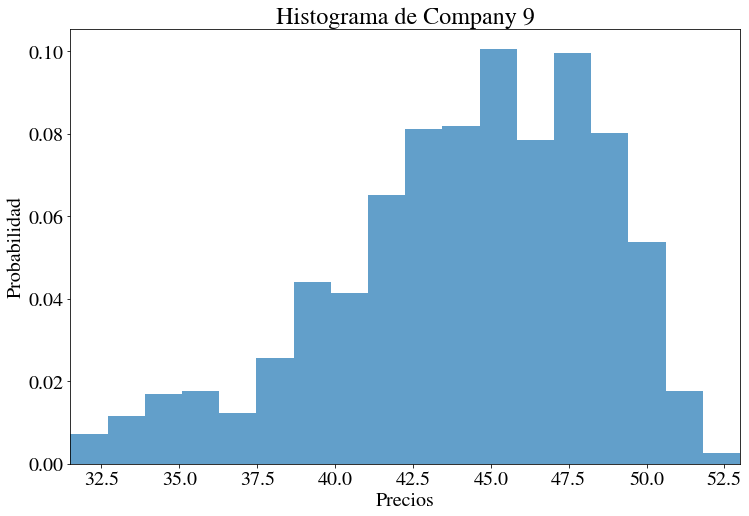

In [19]:
matplotlib.rcParams.update({'font.size': 20, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

fig = plt.figure(figsize=(12,8))

plt.hist(data['Company 9'], bins = 'fd', alpha=0.7, density = True) # fd = regla de Freedman-Diaconis
plt.xlim(data['Company 9'].min(), data['Company 9'].max()) # Límita el valor mínimo y máximo en eje x de la gráfica
plt.xlabel('Precios')
plt.ylabel('Probabilidad')
plt.title('Histograma de Company 9')
plt.show()

In [20]:
kde = KernelDensity(bandwidth = 1.0, kernel='gaussian')
datos_stock_company_9 = data['Company 9'].values
datos_stock_company_9 = datos_stock_company_9.reshape(-1, 1) # Es importante que los datos esten entre 1 y -1
kde.fit(datos_stock_company_9)

KernelDensity()

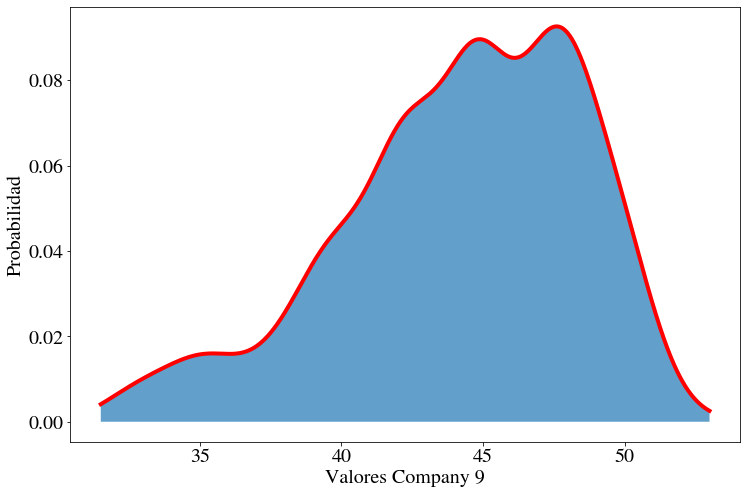

In [21]:
x_minimo_comp_9 = np.min(data['Company 9'].values)
x_maximo_comp_9 = np.max(data['Company 9'].values)
x = np.linspace(x_minimo_comp_9, x_maximo_comp_9, data.shape[0]) # generamos un vector de datos desde el precio mínimo hasta el precio máximo de la compañia 1
Prob_Log = kde.score_samples(x.reshape(-1, 1)) # Es importante que los datos esten entre 1 y -1
                                               # Log = Logarítmico

matplotlib.rcParams.update({'font.size': 20, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

fig = plt.figure(figsize=(12,8))

plt.fill_between(x, np.exp(Prob_Log), alpha = 0.7) # Se muestra la función de densidad de probabilidad estimado por densidad kernel
plt.plot(x, np.exp(Prob_Log), 'r', linewidth = 4) # Se muestra la función de densidad de probabilidad estimado por densidad kernel
plt.xlabel("Valores Company 9")
plt.ylabel("Probabilidad")
plt.show()

Como pueden observar, el kernel gaussiano permitio construir una función de densidad de probabilidad para la compañia 9 (recomiendo hacer una comparación visual con el histograma de la compañia 9 generado anteriormente).

Aunque es un método muy interesante para estimar una distribución de probabilidad sin necesidad de calcular la media o la desviación estándar (es decir, este es un método no paramétrico). No obstante, uno de los inconvenientes es establecer el valor más apropiado del ancho de banda o **bandwidth** que permita mejorar la construcción de la función de densidad de probabilidad. Como este método se utiliza en escenarios de Machine Learning, vamos a utilizar una técnica llamada **gridsearch**, el cual permite encontrar el ancho de banda óptimo para nuestro caso de interés

## Búsqueda de hiperparámetros del ancho de banda óptimo

In [22]:
ancho_de_banda = np.linspace(0.1, 2, 200) # Rango de valores de ancho de banda
GS = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': ancho_de_banda}, cv = 10, error_score = 1e-5) 
# cv = número de doblajes a los datos
GS.fit(datos_stock_company_9)

GridSearchCV(cv=10, error_score=1e-05, estimator=KernelDensity(),
             param_grid={'bandwidth': array([0.1       , 0.10954774, 0.11909548, 0.12864322, 0.13819095,
       0.14773869, 0.15728643, 0.16683417, 0.17638191, 0.18592965,
       0.19547739, 0.20502513, 0.21457286, 0.2241206 , 0.23366834,
       0.24321608, 0.25276382, 0.26231156, 0.2718593 , 0.28140704,
       0.29095477, 0.30050251, 0.31005025, 0.31959799, 0...
       1.67537688, 1.68492462, 1.69447236, 1.7040201 , 1.71356784,
       1.72311558, 1.73266332, 1.74221106, 1.75175879, 1.76130653,
       1.77085427, 1.78040201, 1.78994975, 1.79949749, 1.80904523,
       1.81859296, 1.8281407 , 1.83768844, 1.84723618, 1.85678392,
       1.86633166, 1.8758794 , 1.88542714, 1.89497487, 1.90452261,
       1.91407035, 1.92361809, 1.93316583, 1.94271357, 1.95226131,
       1.96180905, 1.97135678, 1.98090452, 1.99045226, 2.        ])})

In [23]:
ancho_banda_optimo = GS.best_params_
print("Ancho de banda óptimo = ", ancho_banda_optimo)

Ancho de banda óptimo =  {'bandwidth': 2.0}


Utilizando el valor recomendado por el método

In [24]:
kde_opt = KernelDensity(bandwidth = 2, kernel='gaussian')
kde_opt.fit(datos_stock_company_9)

KernelDensity(bandwidth=2)

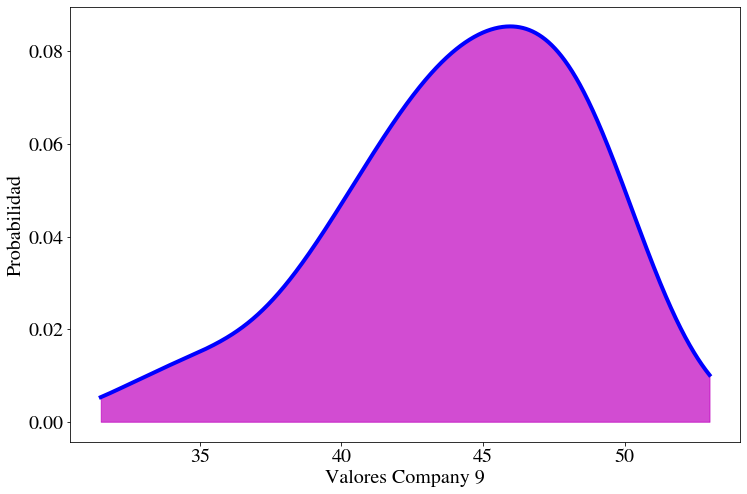

In [25]:
Prob_Log_opt = kde_opt.score_samples(x.reshape(-1, 1)) # Es importante que los datos esten entre 1 y -1

matplotlib.rcParams.update({'font.size': 20, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

fig = plt.figure(figsize=(12,8))

plt.fill_between(x, np.exp(Prob_Log_opt), alpha = 0.7, color = 'm') # Se muestra la función de densidad de probabilidad estimado por densidad kernel
plt.plot(x, np.exp(Prob_Log_opt), 'b', linewidth = 4) # Se muestra la función de densidad de probabilidad estimado por densidad kernel
plt.xlabel("Valores Company 9")
plt.ylabel("Probabilidad")
plt.show()

¿Qué sucedería si cambiamos la función kernel?

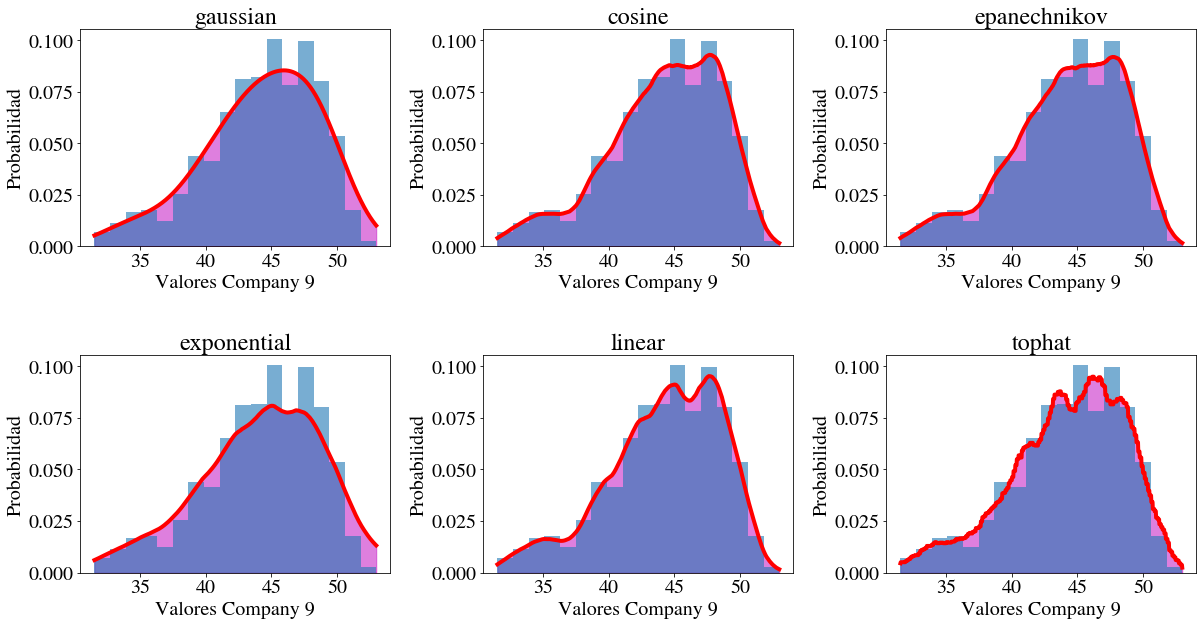

In [26]:
kernels = ['gaussian', 'cosine', 'epanechnikov', 'exponential', 'linear', 'tophat']
colores = ['r', 'm', 'g', 'brown', 'ForestGreen', 'orange']

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
arreglo = np.arange(6) + 231

for k, indice in zip(kernels, arreglo):
    kde = KernelDensity(kernel=k, bandwidth = 2)
    kde.fit(datos_stock_company_9)
    Prob_Log = kde.score_samples(x.reshape(-1, 1))
    plt.subplot(indice)
    plt.fill_between(x, np.exp(Prob_Log), alpha = 0.5, color = 'm')
    plt.plot(x, np.exp(Prob_Log), 'r', linewidth = 4) # Se muestra la función de densidad de probabilidad estimado por densidad kernel
    plt.hist(data['Company 9'], bins = 'fd', alpha=0.6, density = True) # fd = regla de Freedman-Diaconis
    plt.xlabel("Valores Company 9")
    plt.ylabel("Probabilidad")
    plt.title(k)

fig.subplots_adjust(hspace=0.5, wspace=.3)
plt.show()

## Calculando probabilidades a partir de la densidad kernel

¿Se puede aplicar cdf (función de densidad acumulada) para luego estimar probabilidades con este tipo de distribución de probabilidad?

In [27]:
print(kernel_switch.keys()) # lista de funciones kernel

dict_keys(['gau', 'epa', 'uni', 'tri', 'biw', 'triw', 'cos', 'cos2', 'tric'])


In [28]:
kde = sm.nonparametric.KDEUnivariate(datos_stock_company_9)
kde.fit(kernel = 'gau')

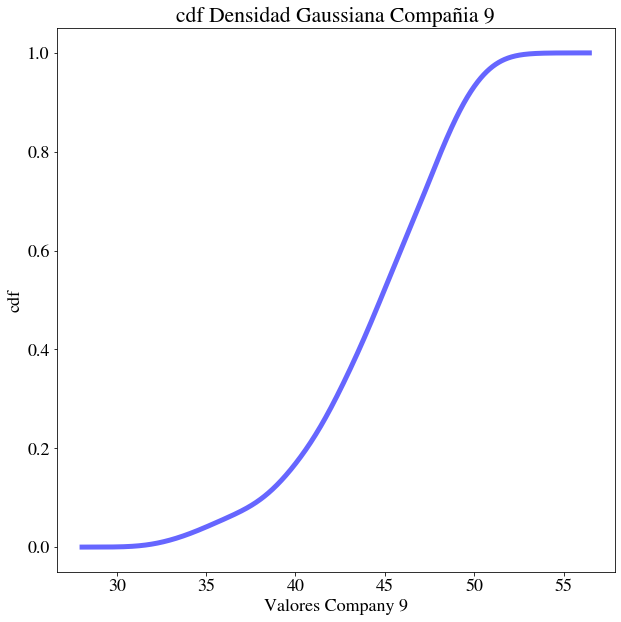

In [29]:
y = kde.density # Probabilidades
p_cdf = kde.cdf # función de densidad de probabilidad acumulada
x_cdf = kde.support 

matplotlib.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

plt.figure(figsize=(10,10))
plt.plot(x_cdf, p_cdf, 'b-', lw = 5, alpha = 0.6, label='cdf Gaussiano')
plt.xlabel('Valores Company 9')
plt.ylabel('cdf')
plt.title('cdf Densidad Gaussiana Compañia 9')
plt.show()

¿Cuál es la probabilidad que los valores estén entre **45** y **50**?

In [30]:
valor_1 = 45
valor_2 = 50

diferencia_1 = np.abs(x_cdf - valor_1)
indice_1 = diferencia_1.argmin() # Se calcula el argumento del mínimo valor de un arreglo de valores. Argumento en programación sería el índice.
valor_cercano_1 = x_cdf[indice_1]

diferencia_2 = np.abs(x_cdf - valor_2)
indice_2 = diferencia_2.argmin() # Se calcula el argumento del mínimo valor de un arreglo de valores. Argumento en programación sería el índice.
valor_cercano_2 = x_cdf[indice_2]

Probabilidad_1 = p_cdf[indice_1]
Probabilidad_2 = p_cdf[indice_2]
Probabilidad_1_2 = Probabilidad_2 - Probabilidad_1

print('Valor aproximado 1 = ', valor_cercano_1)
print('Valor aproximado 2 = ', valor_cercano_2)
print('La probabilidad de encontrar productos de Company 9 con valores entre 45 y 50: ', Probabilidad_1_2)

Valor aproximado 1 =  45.01100652407939
Valor aproximado 2 =  50.0057921957808
La probabilidad de encontrar productos de Company 9 con valores entre 45 y 50:  0.40878676848426077


¿Cuál es la probabilidad que los valores sean **superiores a 50**?

In [31]:
valor = 50
diferencia = np.abs(x_cdf - valor)
indice = diferencia.argmin() # Se calcula el argumento del mínimo valor de un arreglo de valores. Argumento en programación sería el índice.
Probabilidad = 1 - p_cdf[indice]
print('La probabilidad de encontrar productos de  Company 9 con valores superiores a 50: ', Probabilidad)

La probabilidad de encontrar productos de  Company 9 con valores superiores a 50:  0.06773142921412345


¿Cuál es la probabilidad que los valores sean **inferiores a 40**?

In [32]:
valor = 40
diferencia = np.abs(x_cdf - valor)
indice = diferencia.argmin() # Se calcula el argumento del mínimo valor de un arreglo de valores. Argumento en programación sería el índice.
Probabilidad_inf = p_cdf[indice]
print('La probabilidad de encontrar productos de  Company 9 con valores inferiores a 40: ', Probabilidad_inf)

La probabilidad de encontrar productos de  Company 9 con valores inferiores a 40:  0.16835879526616163


## Matriz de Dispersión de Datos con Funciones Kernel

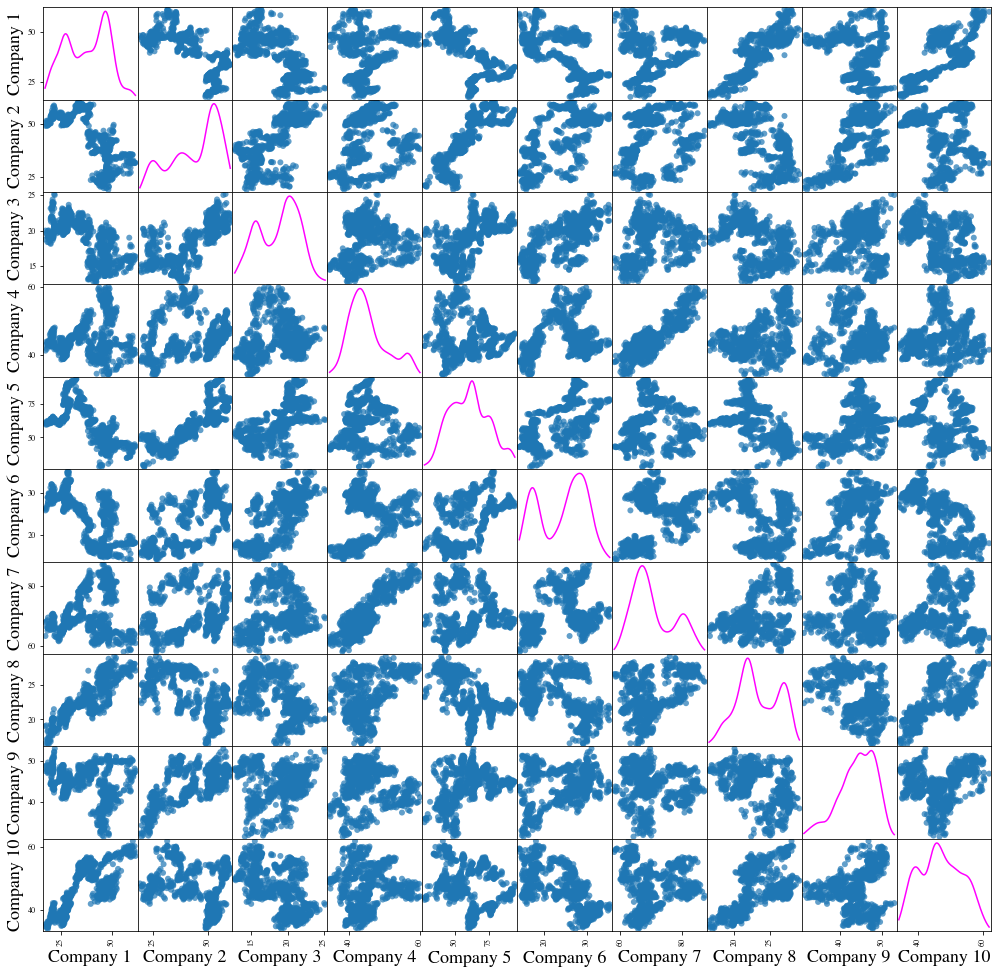

In [33]:
scatter = pd.plotting.scatter_matrix(data, alpha=0.7, grid = True, marker = 'o', 
                           diagonal = "kde", figsize = (17,17),
                           density_kwds = {"color": "magenta"}) # Grafica de dispersión e histograma
plt.show()

In [34]:
X_valores = []
Probabilidades = []
ft = np.arange(0, data.shape[1])
modelo_kde = []

for feature in ft:
  xdata,ydata = scatter[feature,feature].get_lines()[0].get_data()
  X_valores.append(xdata)
  Probabilidades.append(ydata)

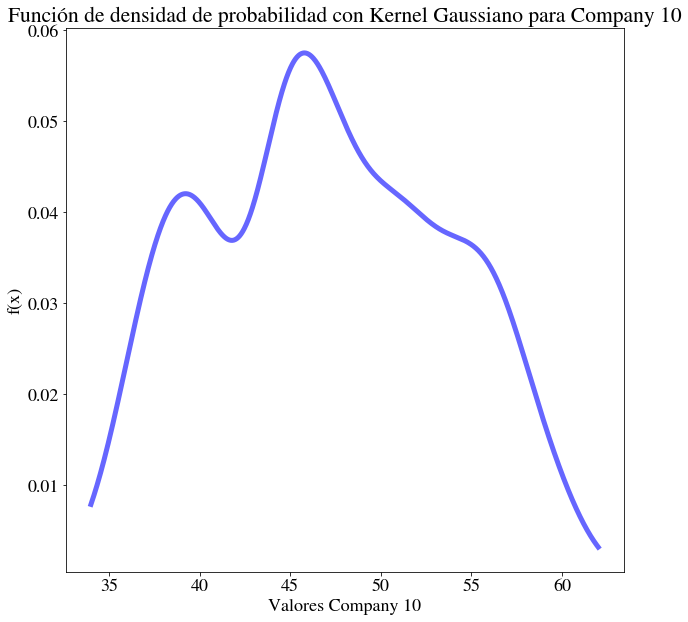

In [35]:
plt.figure(figsize=(10,10))
plt.plot(X_valores[9], Probabilidades[9], 'b-', lw = 5, alpha = 0.6, label='Función Kernel Gaussiano Company 10')
plt.xlabel('Valores Company 10')
plt.ylabel('f(x)')
plt.title('Función de densidad de probabilidad con Kernel Gaussiano para Company 10')
plt.show()

## Programa Complementario para cálculo de probabilidades con CDF en Densidad Kernel

In [36]:
def Calculo_Prob_CDF_Kernel(x, kernel, x_referencia):
  # ['gau', 'epa', 'uni', 'tri', 'biw', 'triw', 'cos', 'cos2', 'tric']
  x_array = x.values
  x_array = x_array.reshape(-1, 1)
  kde = sm.nonparametric.KDEUnivariate(x_array)
  kde.fit(kernel = kernel)
  p_cdf = kde.cdf
  x_cdf = kde.support
  if len(x_referencia) == 1:
    diferencia = np.abs(x_cdf - x_referencia)
    indice = diferencia.argmin()
    Probabilidades = [p_cdf[indice], 1 - p_cdf[indice]]
  else:
    diferencia_1, diferencia_2 = [np.abs(x_cdf - x_referencia[0]),  np.abs(x_cdf - x_referencia[1])]
    indice_1, indice_2 = [diferencia_1.argmin(), diferencia_2.argmin()] # Se calcula el argumento del mínimo valor de un arreglo de valores. Argumento en programación sería el índice.
    Probabilidad_1 = p_cdf[indice_1]
    Probabilidad_2 = p_cdf[indice_2]
    Probabilidades = Probabilidad_2 - Probabilidad_1
  return Probabilidades

In [37]:
P = Calculo_Prob_CDF_Kernel(data['Company 10'], 'gau', [50])
print(P)

[0.6573957536365619, 0.3426042463634381]


In [38]:
P_dif = Calculo_Prob_CDF_Kernel(data['Company 10'], 'gau', [45,50])
print(P_dif)

0.25714562027346144


In [39]:
Probabilidades = []
X_ref = [50]
ft = data.columns
ker = 'gau'

for feature in ft:
  P = Calculo_Prob_CDF_Kernel(data[feature], ker, X_ref)
  Probabilidades.append(P)

Tabla_Probabilidades = pd.DataFrame(Probabilidades, index = data.columns, columns = ['Probabilidad por debajo de x', 'Probabilidad por encima de x'])
display(Tabla_Probabilidades)

,Probabilidad por debajo de x,Probabilidad por encima de x
Company 1,0.864698,0.135302
Company 2,0.590905,0.409095
Company 3,0.999998,0.000002
Company 4,0.795513,0.204487
Company 5,0.260294,0.739706
Company 6,0.999993,0.000007
Company 7,0.000003,0.999997
Company 8,0.999997,0.000003
Company 9,0.932269,0.067731
Company 10,0.657396,0.342604


In [40]:
Probabilidades = []
X_ref = [45,50]
ft = data.columns
ker = 'gau'

for feature in ft:
  P_diff = Calculo_Prob_CDF_Kernel(data[feature], ker, X_ref)
  Probabilidades.append(P_diff)

Tabla_Probabilidades_Diff = pd.DataFrame(Probabilidades, index = data.columns, columns = ['Probabilidad en un rango x_inicial y x_final'])
display(Tabla_Probabilidades_Diff)

,Probabilidad en un rango x_inicial y x_final
Company 1,0.189251
Company 2,0.130199
Company 3,0.000000
Company 4,0.228326
Company 5,0.103203
Company 6,0.000000
Company 7,0.000000
Company 8,0.000000
Company 9,0.408787
Company 10,0.257146
